In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import HeUniform

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve

import csv

import sklearn
from sklearn.model_selection import train_test_split
import os
import numpy as np
import os
import shutil
import random
from matplotlib import pyplot as plt
import matplotlib

print("\nLibraries\n-----------------------------")
print(f"Tensorflow: {tf.__version__}")
print(f"Scikit Learn: {sklearn.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")


Libraries
-----------------------------
Tensorflow: 2.12.0
Scikit Learn: 1.3.1
Numpy: 1.22.0
Matplotlib: 3.7.0


In [2]:
def count_files_in_directory(directory_path):
    total_files = 0

    for root, _, files in os.walk(directory_path):
        total_files += len(files)

    return total_files

In [3]:
def create_test_set(source_dir, test_dir, class_names, test_percent):
    os.makedirs(test_dir, exist_ok = True)
    
    for class_name in class_names:
        class_source_dir = os.path.join(source_dir, class_name)
        class_test_dir = os.path.join(test_dir, class_name)
        os.makedirs(class_test_dir, exist_ok = True)
        
        images = os.listdir(class_source_dir)
        num_images = len(images)
        num_test_images = int(test_percent * num_images)
        
        test_indices = random.sample(range(num_images), num_test_images)
        
        for index in test_indices:
            image_name = images[index]
            source_path = os.path.join(class_source_dir, image_name)
            target_path = os.path.join(class_test_dir, image_name)
            shutil.move(source_path, target_path)

In [4]:
# Define image dimensions and other parameters
img_height, img_width = 80, 400

data_dir = "./DS1/Train"

# test set
train_data_dir = "./DS1/Train"
test_data_dir = "./DS1/Test"
valid_data_dir = "./DS1/Validset"

class_names = os.listdir(train_data_dir)

first_execution = True

if first_execution:
    create_test_set(train_data_dir, test_data_dir, class_names, 0.3)
    create_test_set(train_data_dir, valid_data_dir, class_names, 0.2)

In [5]:
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1.0 / 255.0
)

data_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = 32,
    class_mode = 'binary',
    shuffle = True
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_generator = validation_datagen.flow_from_directory(
        valid_data_dir,
        target_size = (img_height, img_width),
        batch_size = 14,
        class_mode = 'binary',
        shuffle = True
)

Found 302 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


In [6]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    batch_size = count_files_in_directory(test_data_dir),
    class_mode = 'binary',
    shuffle = False
)

Found 159 images belonging to 2 classes.


In [7]:
input_layer = Input(shape = (img_height, img_width, 3))

# first block

conv1 = Conv2D(
    filters = 32, 
    kernel_size = (3, 3), 
    strides = (2, 2), 
    padding = 'same',
    kernel_initializer = HeUniform()
)(input_layer)
conv1 = Activation('relu')(conv1)
norm1 = BatchNormalization()(conv1)

conv2 = Conv2D(
    filters = 32, 
    kernel_size = (3, 3), 
    strides = (2, 2), 
    padding = 'same',
    kernel_initializer = HeUniform()
)(norm1)
conv2 = Activation('relu')(conv2)
norm2 = BatchNormalization()(conv2)

pool1 = MaxPooling2D(
    pool_size = (2, 2), 
    strides = (1, 1), 
    padding = 'same'
)(norm2)

dropout1 = Dropout(0.2)(pool1)

# second block

conv3 = Conv2D(
    filters = 64, 
    kernel_size = (3, 3), 
    strides = (2, 2), 
    padding = 'same',
    kernel_initializer = HeUniform()
)(dropout1)
conv3 = Activation('relu')(conv3)
norm3 = BatchNormalization()(conv3)

conv4 = Conv2D(
    filters = 64, 
    kernel_size = (3, 3), 
    strides = (2, 2), 
    padding = 'same',
    kernel_initializer = HeUniform()
)(norm3)
conv4 = Activation('relu')(conv4)
norm4 = BatchNormalization()(conv4)

pool2 = MaxPooling2D(
    pool_size = (2, 2), 
    strides = (1, 1),
    padding = 'same'
)(norm4)

dropout2 = Dropout(0.3)(pool2)

# third block

conv5 = Conv2D(
    filters = 128, 
    kernel_size = (3, 3), 
    strides = (2, 2), 
    padding = 'same',
    kernel_initializer = HeUniform()
)(dropout2)
conv5 = Activation('relu')(conv5)
norm5 = BatchNormalization()(conv5)

conv6 = Conv2D(
    filters = 128, 
    kernel_size = (3, 3), 
    strides = (2, 2), 
    padding = 'same',
    kernel_initializer = HeUniform()
)(norm5)
conv6 = Activation('relu')(conv6)
norm6 = BatchNormalization()(conv6)

pool3 = MaxPooling2D(
    pool_size = (2, 2), 
    strides = (1, 1), 
    padding = 'same'
)(norm6)

dropout3 = Dropout(0.4)(pool3)

# fourth block

conv7 = Conv2D(
    filters = 512, 
    kernel_size = (3, 3), 
    strides = (2, 2),  
    padding = 'same',
    kernel_initializer = HeUniform()
)(dropout3)
conv7 = Activation('relu')(conv7)
norm7 = BatchNormalization()(conv7)

conv8 = Conv2D(
    filters = 512, 
    kernel_size = (3, 3), 
    strides = (2, 2), 
    padding = 'same',
    kernel_initializer = HeUniform()
)(norm7)
conv8 = Activation('relu')(conv8)
norm8 = BatchNormalization()(conv8)

pool4 = MaxPooling2D(
    pool_size = (2, 2), 
    strides = (1, 1), 
    padding = 'same'
)(norm8)

dropout4 = Dropout(0.4)(pool4)

flatten = Flatten()(dropout4)

dense1 = Dense(128, activation = 'relu')(flatten)
norm9 = BatchNormalization()(dense1)
dropout5 = Dropout(0.5)(norm9)
output_layer = Dense(1,
                      activation = 'sigmoid')(dropout5)

model = Model(inputs = input_layer, outputs = output_layer)

In [8]:
model.compile(optimizer = SGD(learning_rate = 0.001, momentum = 0.9),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(data_generator, epochs = 100,
                    validation_data = validation_generator)

Epoch 1/100
10/10 [==============================] - 7s 529ms/step - loss: 1.0342 - accuracy: 0.5066 - val_loss: 0.7037 - val_accuracy: 0.2568
Epoch 2/100
10/10 [==============================] - 5s 459ms/step - loss: 0.9007 - accuracy: 0.5828 - val_loss: 0.5849 - val_accuracy: 0.9324
Epoch 3/100
10/10 [==============================] - 5s 471ms/step - loss: 0.9067 - accuracy: 0.6026 - val_loss: 0.4628 - val_accuracy: 0.9189
Epoch 4/100
10/10 [==============================] - 5s 499ms/step - loss: 0.8435 - accuracy: 0.6060 - val_loss: 0.4151 - val_accuracy: 0.9189
Epoch 5/100
10/10 [==============================] - 5s 474ms/step - loss: 0.8369 - accuracy: 0.6556 - val_loss: 0.4148 - val_accuracy: 0.9189
Epoch 6/100
10/10 [==============================] - 5s 500ms/step - loss: 0.7385 - accuracy: 0.6291 - val_loss: 0.4082 - val_accuracy: 0.9189
Epoch 7/100
10/10 [==============================] - 5s 460ms/step - loss: 0.7375 - accuracy: 0.6391 - val_loss: 0.3830 - val_accuracy: 0.9189

Epoch 58/100
10/10 [==============================] - 5s 471ms/step - loss: 0.2933 - accuracy: 0.9106 - val_loss: 0.2614 - val_accuracy: 0.9189
Epoch 59/100
10/10 [==============================] - 5s 471ms/step - loss: 0.2964 - accuracy: 0.9172 - val_loss: 0.2622 - val_accuracy: 0.9189
Epoch 60/100
10/10 [==============================] - 5s 459ms/step - loss: 0.3174 - accuracy: 0.8874 - val_loss: 0.2637 - val_accuracy: 0.9189
Epoch 61/100
10/10 [==============================] - 5s 493ms/step - loss: 0.3026 - accuracy: 0.8907 - val_loss: 0.2628 - val_accuracy: 0.9189
Epoch 62/100
10/10 [==============================] - 5s 483ms/step - loss: 0.3172 - accuracy: 0.8907 - val_loss: 0.2604 - val_accuracy: 0.9189
Epoch 63/100
10/10 [==============================] - 5s 499ms/step - loss: 0.3072 - accuracy: 0.9040 - val_loss: 0.2585 - val_accuracy: 0.9189
Epoch 64/100
10/10 [==============================] - 5s 511ms/step - loss: 0.2761 - accuracy: 0.9272 - val_loss: 0.2567 - val_accuracy:

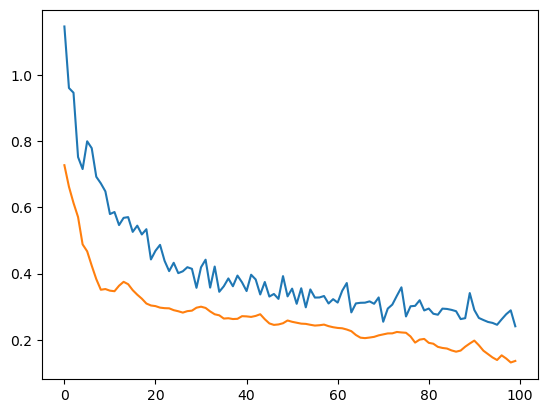

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

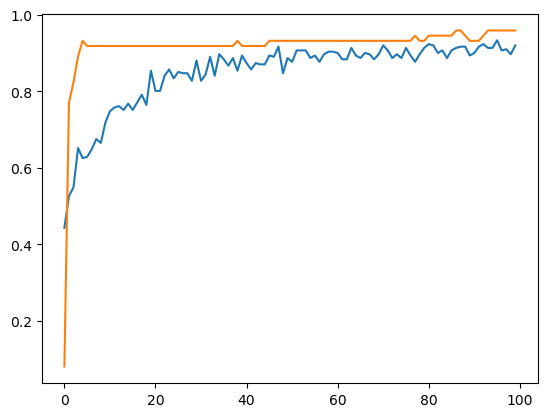

In [10]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [11]:
real_labels = []
original_probs = []
original_labels = []
adversarial_probs = []
adversarial_labels = []

batch_images, batch_labels = next(test_generator)

for individual_image in range(batch_images.shape[0]):
    single_image_array = batch_images[individual_image]
    single_image_label = batch_labels[individual_image]
    
    original_prob = model.predict(np.expand_dims(single_image_array, axis=0))
    original_pred = np.around(original_prob)
    
    target_image = tf.convert_to_tensor(np.expand_dims(single_image_array, axis=0))
    with tf.GradientTape() as tape:
        tape.watch(target_image)
        prediction = model(target_image)
        loss = tf.keras.losses.binary_crossentropy(single_image_label, prediction[0])
    gradient = tape.gradient(loss, target_image)
    perturbed_image = target_image + 0.007 * tf.sign(gradient)
    
    adversarial_prob = model.predict(np.expand_dims(perturbed_image[0], axis=0))
    adversarial_pred = np.around(adversarial_prob)
    
    real_labels.append(single_image_label)
    original_probs.append(original_prob)
    adversarial_probs.append(adversarial_prob)
    original_labels.append(original_pred)
    adversarial_labels.append(adversarial_pred)

original_probs = np.array(original_probs).reshape(-1)
adversarial_probs = np.array(adversarial_probs).reshape(-1)
adversarial_labels = np.array(adversarial_labels).reshape(-1)
original_labels = np.array(original_labels).reshape(-1)

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 22ms/step


In [12]:
indices0 = [index for index, value in enumerate(real_labels) if value == 0]
indices1 = [index for index, value in enumerate(real_labels) if value == 1]

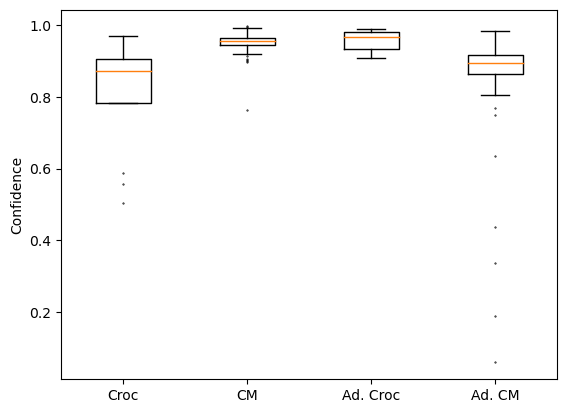

In [13]:
original_croc_probs = original_probs[indices0]
original_cm_probs = original_probs[indices1]
adversarial_croc_probs = adversarial_probs[indices0]
adversarial_cm_probs = adversarial_probs[indices1]

data = [original_croc_probs, original_cm_probs, adversarial_croc_probs,
       adversarial_cm_probs]
labels = ["Croc", "CM", "Ad. Croc", "Ad. CM"]
plt.boxplot(data, flierprops = dict(
    marker = ".", markersize = 1
))
plt.xticks([1, 2, 3, 4], labels)
plt.ylabel("Confidence")
plt.show()

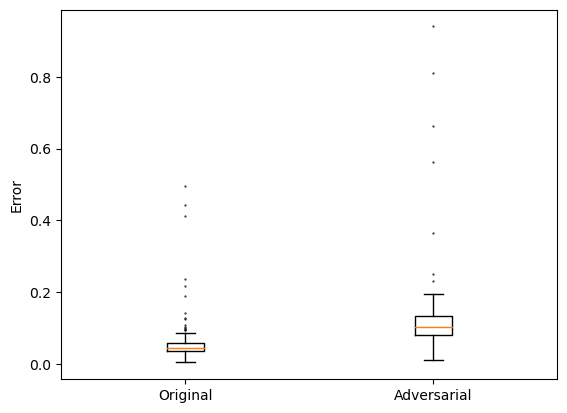

In [14]:
adversarial_errors = np.sqrt(np.square(np.concatenate((1 - adversarial_croc_probs, 1 - adversarial_cm_probs))))
original_errors = np.sqrt(np.square(np.concatenate((1 - original_croc_probs, 1 - original_cm_probs))))

data = [original_errors, adversarial_errors]
labels = ["Original", "Adversarial"]

plt.boxplot(data, flierprops = dict(
    marker = ".", markersize = 1
))
plt.xticks([1, 2], labels)
plt.ylabel("Error")
plt.show()

In [15]:
print(f"Original Crocodile Loss {np.sqrt(np.mean(np.square(1 - original_croc_probs))) * 100:.2f}%")
print(f"Original Cut Mark Loss {np.sqrt(np.mean(np.square(1 - original_cm_probs))) * 100:.2f}%")
print(f"Adversarial Crocodile Loss {np.sqrt(np.mean(np.square(1 - adversarial_croc_probs))) * 100:.2f}%")
print(f"Adversarial Cut Mark Loss {np.sqrt(np.mean(np.square(1 - adversarial_cm_probs))) * 100:.2f}%")
print("\n----------------------------------\n")
print(f"Original Loss {np.sqrt(np.mean(np.square(np.concatenate((1 - original_croc_probs, 1 - original_cm_probs))))) * 100:.2f}%")
print(f"Adversarial Loss {np.sqrt(np.mean(np.square(np.concatenate((1 - adversarial_croc_probs, 1 - adversarial_cm_probs))))) * 100:.2f}%")

Original Crocodile Loss 24.41%
Original Cut Mark Loss 5.29%
Adversarial Crocodile Loss 4.98%
Adversarial Cut Mark Loss 17.13%

----------------------------------

Original Loss 8.63%
Adversarial Loss 16.48%


In [16]:
print(classification_report(real_labels, adversarial_labels))
print(confusion_matrix(real_labels, adversarial_labels))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        13
         1.0       0.92      0.97      0.94       146

    accuracy                           0.89       159
   macro avg       0.46      0.49      0.47       159
weighted avg       0.84      0.89      0.87       159

[[  0  13]
 [  4 142]]


In [17]:
print(classification_report(real_labels, original_labels))
print(confusion_matrix(real_labels, original_labels))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        13
         1.0       0.92      1.00      0.96       146

    accuracy                           0.92       159
   macro avg       0.46      0.50      0.48       159
weighted avg       0.84      0.92      0.88       159

[[  0  13]
 [  0 146]]


C:\Users\l.courtenay\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\l.courtenay\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\l.courtenay\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

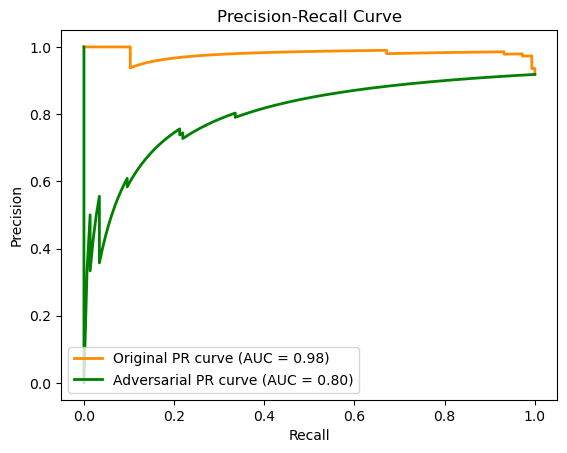

Original PR AUC: 0.9812364923561627
Adversarial PR AUC: 0.7993651541729154


In [18]:
precision_original, recall_original, _ = precision_recall_curve(real_labels, original_probs)
pr_auc_original = auc(recall_original, precision_original)

precision_adversarial, recall_adversarial, _ = precision_recall_curve(real_labels, adversarial_probs)
pr_auc_adversarial = auc(recall_adversarial, precision_adversarial)

# Plot Precision-Recall curves
plt.figure()
plt.plot(recall_original, precision_original, color='darkorange', lw=2,
         label='Original PR curve (AUC = %0.2f)' % pr_auc_original)
plt.plot(recall_adversarial, precision_adversarial, color='green', lw=2,
         label='Adversarial PR curve (AUC = %0.2f)' % pr_auc_adversarial)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

print("Original PR AUC:", pr_auc_original)
print("Adversarial PR AUC:", pr_auc_adversarial)

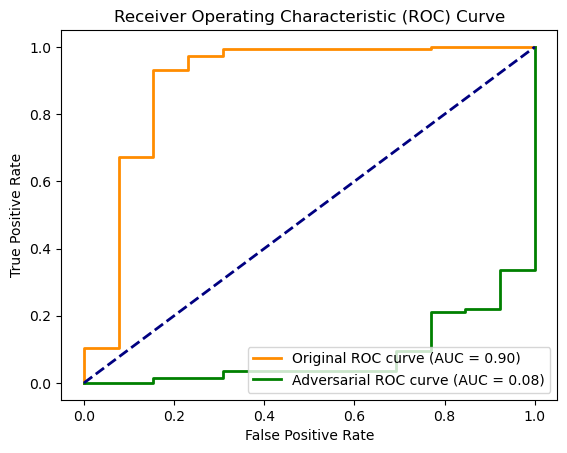

Original ROC AUC: 0.8951527924130663
Adversarial ROC AUC: 0.08166491043203372


In [19]:
fpr_original, tpr_original, _ = roc_curve(real_labels, original_probs)
roc_auc_original = auc(fpr_original, tpr_original)

fpr_adversarial, tpr_adversarial, _ = roc_curve(real_labels, adversarial_probs)
roc_auc_adversarial = auc(fpr_adversarial, tpr_adversarial)

plt.figure()
plt.plot(fpr_original, tpr_original, color='darkorange', lw=2,
         label='Original ROC curve (AUC = %0.2f)' % roc_auc_original)
plt.plot(fpr_adversarial, tpr_adversarial, color='green', lw=2,
         label='Adversarial ROC curve (AUC = %0.2f)' % roc_auc_adversarial)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("Original ROC AUC:", roc_auc_original)
print("Adversarial ROC AUC:", roc_auc_adversarial)